In [1]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from time import sleep
import sys

import nltk # for nlp on articles
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# I. Data Acquisition

## Data Acquisition Utils

In [96]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
        return 0
        list_articles = []
        for c in category_members.values():
            if c.ns == 0:
                list_articles.append(c) 
                #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = DataAquisitionUtils.fetch_category_members(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        len_time = len(list_articles)*0.05
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int(compt/len_time), int(5*compt/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        len_time = len(list_articles)*0.05
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            try: 
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int((i+1)/len_time), int(5*(i+1)/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return words_df
    
    @staticmethod
    def make_features(words, important_words_df, weights = True):
        explode_df = words.explode('words')
        if (weights == True) :
            explode_df = explode_df.merge(important_words_df, on = 'words', how = 'right')
            df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
            df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
            df3 = pd.pivot_table(df2, values = 'tfidf',  index = 'article', columns=['words'])
        else : 
            explode_df['exist'] = np.ones(len(explode_df))
            df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
            df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
            df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
        display(df3.head(10))
        features = df3.values
        return features

## NLP Utilities

In [4]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()
        
        dense = tf_idf_vector.todense()
        denselist = dense.tolist()
                
        #tf_idf = matrix where rows are articles and columns are words and values are tfidf score for word in article
        tf_idf = pd.DataFrame(data=denselist, columns=feature_names, index=words_df['article'])
        
        #these are the words that have the biggest tfidf score
        important_words = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf']).head(nb_words).index.values
        
        #only keep the most important words in matrix
        tf_idf = tf_idf[important_words]

        return tf_idf

## Data Acquisition Pipeline

### Fetching the articles of interest

In [97]:
aquire = DataAquisitionUtils()

In [6]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")

In [7]:
# EXECUTE IF YOU DO NOT HAVE PICKLES
# religion_articles = aquire.fetch_category_members(religion_page.categorymembers,0,1)
# science_articles = aquire.fetch_category_members(science_page.categorymembers)

In [8]:
religion_articles = pd.read_pickle('./religion_articles')
science_articles = pd.read_pickle('./science_articles')

#### Hyperlink matrix

In [9]:
# EXECUTE IF YOU DO NOT HAVE CSV
# list_articles = religion_articles + science_articles
# adjacency_matrix = aquire.hyperlinks_matrix(list_articles)
# num_edges = np.count_nonzero(adjacency_matrix)
# print(f"Number of edges in the feature graph: {num_edges}")
# np.savetxt('hyperlinks.csv', adjacency_matrix)

In [10]:
df = pd.read_csv('./hyperlinks.csv.zip')

### Taking the words with the highest TF-IDF

In [11]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

In [12]:
#religion_df = aquire.take_words(religion_articles, stop_words)
religion_df = religion_articles
religion_df = religion_df.drop_duplicates('article')

In [13]:
#science_df = aquire.take_words(science_articles, stop_words)
science_df = science_articles
science_df = science_df.drop_duplicates('article')

In [66]:
religion_labeled_df = religion_df.copy()
religion_labeled_df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

#words_df_reduced = pd.concat([religion_labeled_df[:int(len(religion_labeled_df)/10)],\
#                      science_labeled_df[:int(len(science_labeled_df)/10)]], ignore_index=True)
words_df_reduced = pd.concat([religion_labeled_df[:700], science_labeled_df[:700]], ignore_index=True)
                              
labels_df = pd.DataFrame(words_df_reduced['label'])
words_df_reduced

,article,words,label
0,Religion,"[religion, social-cultural, system, designated...",0
1,African and African-American women in Christia...,"[christianity, africa, began, egypt, middle, 1...",0
2,Religion and agriculture,"[religion, agriculture, closely, associated, s...",0
3,American Anglican Church,"[anglican, church, north, america, acna, chris...",0
4,American Humanist Association,"[american, humanist, association, aha, non-pro...",0
...,...,...,...
1395,Scientific equipment optician,"[scientific, equipment, optician, individual, ...",1
1396,Volcanologist,"[volcanologist, vulcanologist, geologist, stud...",1
1397,Allen Brain Atlas,"[allen, mouse, human, brain, atlases, projects...",1
1398,Allen Institute for Brain Science,"[allen, institute, brain, science, seattle-bas...",1


In [15]:
nlpu = NLPUtilities()

In [16]:
# UNCOMMENT & EXECUTE IF YOU DO NOT HAVE tf_idf_1400_articles.pickle
#tf_idf = nlpu.TF_IDF(words_df_reduced, 100)
tf_idf = pd.read_pickle('tf_idf_1400_articles.pickle')
tf_idf

,science,religion,religious,also,god,book,scientific,research,one,church,...,review,spiritual,information,system,however,john,islam,group,years,based
article,,,,,,,,,,,,,,,,,,,,,
Religion,0.040566,0.543287,0.261171,0.040955,0.040272,0.005691,0.020897,0.000000,0.059069,0.035598,...,0.004107,0.03139,0.000000,0.030415,0.026056,0.013743,0.075973,0.026332,0.000000,0.023621
African and African-American women in Christianity,0.000000,0.023470,0.039923,0.033911,0.006669,0.005654,0.000000,0.005804,0.013043,0.219298,...,0.000000,0.00000,0.007334,0.000000,0.028767,0.000000,0.053285,0.019623,0.006092,0.005868
Religion and agriculture,0.000000,0.069755,0.000000,0.040315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069755
American Anglican Church,0.000000,0.001558,0.003028,0.017105,0.005311,0.006004,0.000000,0.000000,0.012696,0.259163,...,0.000000,0.00000,0.000000,0.000000,0.003055,0.003625,0.002358,0.003473,0.004852,0.000000
American Humanist Association,0.000000,0.009570,0.046511,0.019358,0.038071,0.000000,0.000000,0.004733,0.007091,0.011538,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.016704,0.000000,0.005334,0.004968,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scientific equipment optician,0.000000,0.000000,0.000000,0.049731,0.000000,0.000000,0.029000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.100127,0.000000,0.000000,0.000000,0.000000
Volcanologist,0.023798,0.000000,0.000000,0.016018,0.015751,0.000000,0.000000,0.027415,0.010268,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.013588,0.000000,0.000000,0.015448,0.014387,0.000000
Allen Brain Atlas,0.022973,0.000000,0.000000,0.018039,0.000000,0.000000,0.000000,0.070573,0.003304,0.000000,...,0.000000,0.00000,0.016720,0.005104,0.004372,0.000000,0.000000,0.004971,0.004629,0.004459


In [17]:
important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
important_words_df

,tfidf
science,52.716979
religion,38.608664
religious,34.886210
also,26.213901
god,26.073406
...,...
john,8.422473
islam,8.327312
group,8.310144
years,8.304601


In [18]:
# we don't really need the function make_features anymore 
# features = aquire.make_features(words_df_reduced, important_words_df.reset_index().rename(columns={'index':'words'}))

The weighted TF-IDF matrix $W_{w}$ is our tf_idf dataframe.

In [19]:
features_weight = tf_idf

For the non-weighted TF-IDF $W_{nw}$ where we compute the weights such that for all $i,j$

$(W_{nw})_{i,j} = 1$ if $(W_{w})_{i,j} > 0$, $(W_{nw})_{i,j} = 0$ otherwise

we can do the following

In [20]:
features_no_weight = tf_idf.where(tf_idf <= 0, 1)

For the rest of this project we choose to work with the weighted TF-IDF matrix as it gives more insights into word importance.

In [21]:
features = features_weight

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [22]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [133]:
class MatrixUtils():
    
    @staticmethod
    def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
        """ 
        Fnction to compute the epsilon similarity graph seen in class
        Arguments:
        X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Returns:
        adjacency (n x n ndarray): adjacency matrix of the graph.
        """
        adjacency = np.exp((- X**2)/(2 * sigma**2))
        adjacency[adjacency > epsilon] = 0
        #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
        np.fill_diagonal(adjacency,0)
        return adjacency
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def GFT(signal: np.ndarray):
        """
        Function to compute the fourier transform of a signal
        Arguments:
        signal - the signal for which to compute the fourier transform (in the form of an Numpy array)
        Returns:
        fourier - the fourier transform of the signal provided
        """
        fourier = U.transpose()@signal
        return fourier
    
    @staticmethod
    def iGFT(fourier_coefficients: np.ndarray):
        """
        Function to compute the signal from a fourier transform
        Arguments:
        fourier_coefficients - the fourier coefficients from which to get the signal (in the form of an Numpy array)
        Returns:
        signal - the signal for the fourier coefficients given
        """
        signal = U@fourier_coefficients
        return signal

## Filter Utilities

In [134]:
class FilterUtilities():
    
    @staticmethod    
    def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
        """
        Function to apply an idea filter to a graph
        Arguments:
        x - the signal on which to apply the filter
        spectral_response - the spectral response of the signal
        Returns:
        filtered_graph - a filtered signal
        """
        fourier = MatrixUtils().GFT(x);
        h = np.diag(spectral_response)
        filtered_graph = U@h@fourier
        return filtered_graph

In [135]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## Exploring graph properties

In [136]:
from numpy import dot
from numpy.linalg import norm

def cosine(a,b):
    """
    Function to compute the cosine similarity between two vectors
    Arguments:
    a - first vector
    b - second vector
    Returns:
    cos_sim - the cosine similarity between a and b
    """
    if(norm(a) == 0 or norm(b) == 0):
        return dot(a,b)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [263]:
features_a = np.array(features)

In [357]:
distances = np.array(
    [
        [
            cosine(features_a[i,:],features_a[j,:]) for i in range(0,features_a.shape[0])
        ]
        for j in range(0,features_a.shape[0])
    ]
    ).reshape(features.shape[0],-1)

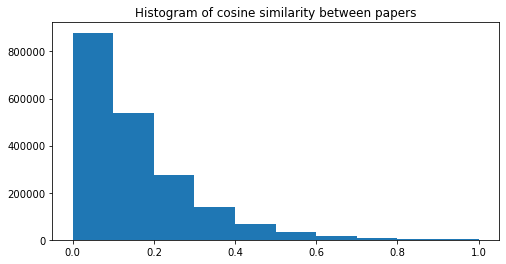

In [265]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of cosine similarity between papers")
plt.hist(distances.flatten());

We notice a heavy-tailed distribution. The similarity between papers is hence concentrated around 0 and 0.2 between most papers but there are some rare papers with very high cosine similarity scores.

In [266]:
important_words_df.head(20)

,tfidf
science,52.716979
religion,38.608664
religious,34.886210
also,26.213901
god,26.073406
book,24.822986
scientific,23.692436
research,22.570687
one,21.420285
church,20.377060


In [267]:
distances = np.nan_to_num(distances)

Let's examine an example of distance distribution for one of the papers.

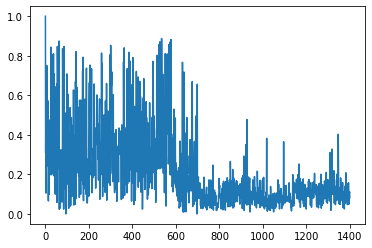

In [268]:
plt.plot(distances[0])

In [33]:
def article_sim_th(threshold, distances=distances):
    feat = np.where(distances > threshold, 1, 0)
    np.fill_diagonal(feat, 0)
    return feat

In [34]:
adjacency_matrix = article_sim_th(0.6)

In [35]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(adjacency_matrix)

In [36]:
# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 1264 nodes and 13639 edges.


In [37]:
# getting the average clustering coefficient of our graph
nx.average_clustering(graph)

0.4904574575937421

## Exploring possible clustering in the graph

In [137]:
matrixu = MatrixUtils()

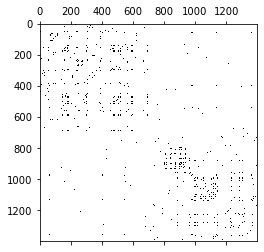

In [39]:
plt.spy(adjacency_matrix)
plt.show()

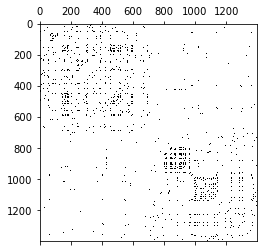

In [358]:
adjacency = matrixu.epsilon_similarity_graph(distances, sigma= 4*np.mean(distances), epsilon=0.7)
plt.spy(adjacency)
plt.show()

In [249]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(distances)
A = neigh.kneighbors_graph(distances)
knn = A.toarray()
np.fill_diagonal(knn,0)

In [250]:
for i in range(len(knn)):
    for j in range(len(knn)):
        if (knn[i,j] != knn[j,i]):
            knn[i,j] = 0
            knn[j,i] = 0

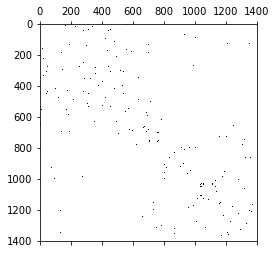

In [251]:
plt.spy(knn)
plt.show()

In [359]:
nodes_df = pd.DataFrame(range(1400), columns = ["X"])
nodes_df["Y"] = np.zeros((1400))

In [360]:
epsilon_df = pd.DataFrame(np.argwhere(adjacency != 0), columns = ["X","Y"] ).drop_duplicates(subset = "X")
epsilon_wo = epsilon_df.merge(nodes_df, on = ["X"], how= "right")

Articles that are not connected

In [361]:
tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]]

,science,religion,religious,also,god,book,scientific,research,one,church,...,review,spiritual,information,system,however,john,islam,group,years,based
article,,,,,,,,,,,,,,,,,,,,,
Pathinettampadi,0.000000,0.000000,0.000000,0.018819,0.000000,0.0,0.000000,0.000000,0.024126,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Retribution principle,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Dennis Marcellino,0.007710,0.008979,0.000000,0.020759,0.020412,0.0,0.000000,0.000000,0.006653,0.000000,...,0.012491,0.0,0.000000,0.000000,0.000000,0.010449,0.0,0.040041,0.000000,0.0
Burkitt Medal,0.000000,0.000000,0.000000,0.032549,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.116938,0.0
Secular paganism,0.000000,0.000000,0.000000,0.014697,0.000000,0.0,0.025711,0.000000,0.000000,0.030659,...,0.000000,0.0,0.000000,0.000000,0.000000,0.029591,0.0,0.000000,0.000000,0.0
Multiconfessionalism,0.000000,0.000000,0.044692,0.026574,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2004 Quetta Ashura massacre,0.000000,0.000000,0.000000,0.010361,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.019985,0.000000,0.0
Albanenses,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.042964,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.064641,0.000000,0.0
Asrestar,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [369]:
distances_wo = np.delete(distances, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 0)
distances_wo = np.delete(distances_wo, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 1)

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using mutual knn-Laplacian Eigenmaps)')

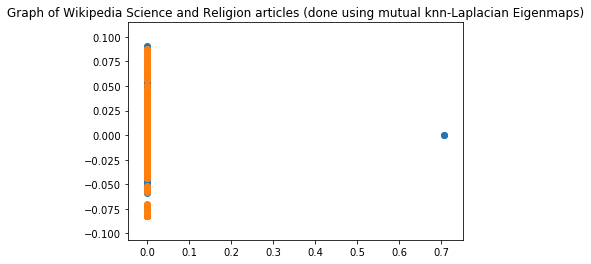

In [212]:
laplacian = matrixu.compute_laplacian(knn, True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(np.nan_to_num(laplacian)) 
twoD_embeddings = (eigenvectors[:,1:3])
plt.scatter(twoD_embeddings[0:700,0], twoD_embeddings[0:700,1], label=1)
plt.scatter(twoD_embeddings[700:2650,0], twoD_embeddings[700:2650,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using mutual knn-Laplacian Eigenmaps)')

In [41]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [44]:
sorted_pr[:10]

[(141, 0.0022892562700181163),
 (888, 0.0022018951756121365),
 (376, 0.0021703103031869083),
 (388, 0.00216482688413386),
 (1149, 0.002121851524451258),
 (297, 0.002116721270151282),
 (419, 0.0021010528137721533),
 (0, 0.0020973334279591653),
 (700, 0.002060695661624799),
 (40, 0.0020074828235951457)]

## Exploring possible clustering in the graph after passing it through an ideal filter

In [45]:
# Computing the laplacian
laplacian = matrixu.compute_laplacian(adjacency, normalize=True)
lam, U = matrixu.spectral_decomposition(np.nan_to_num(laplacian))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


In [46]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

In [47]:
filt = FilterUtilities().ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [48]:
graph_filt = nx.from_numpy_matrix(filt)

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


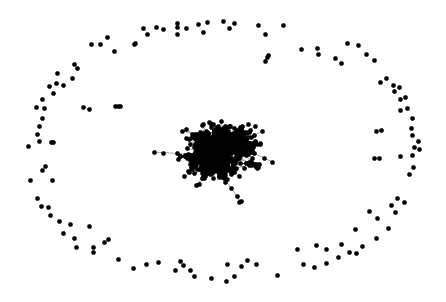

In [49]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/scipy/sparse/coo.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data = self.data.astype(dtype, copy=False)


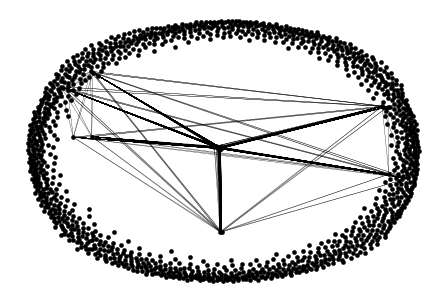

In [50]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [52]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

TypeError: can't convert complex to float

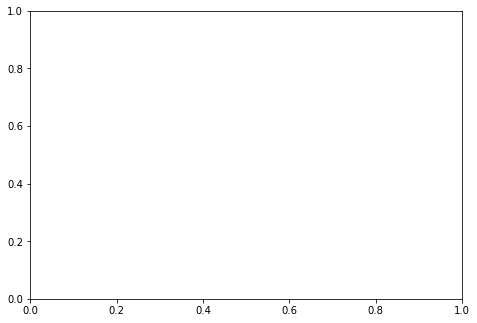

In [53]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [56]:
len(giant_features.nodes)

138

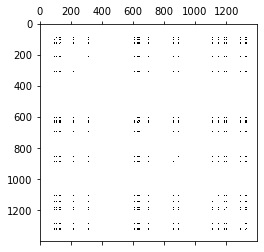

In [59]:
adjacency_filt = matrixu.epsilon_similarity_graph(filt, sigma= np.mean(filt), epsilon=0.60)
plt.spy(adjacency)
plt.show()

## Visualizing the graph obtained

In [129]:
visu = VisUtils()

### Laplacian Eigenmaps

In [373]:
twoD_embeddings = visu.laplacian_eigenmaps(distances, dim=2, sigma= 4*np.mean(distances), epsilon=0.70, normalize=True)

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

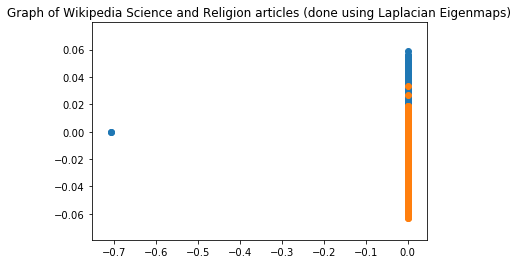

In [374]:
plt.scatter(twoD_embeddings[labels_df[labels_df["label"] == 0].index,0], twoD_embeddings[labels_df[labels_df["label"] == 0].index,1], label=1)
plt.scatter(twoD_embeddings[labels_df[labels_df["label"] == 1].index,0], twoD_embeddings[labels_df[labels_df["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### t-sne

In [386]:
np.argmin(twoD_embeddings, 0)

array([627, 998])

In [388]:
tf_idf.iloc[627]

science      0.000000
religion     0.000000
religious    0.000000
also         0.012478
god          0.000000
               ...   
john         0.000000
islam        0.000000
group        0.000000
years        0.000000
based        0.000000
Name: Anaisa Pye, Length: 100, dtype: float64

In [236]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(knn)

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using tSN-E)')

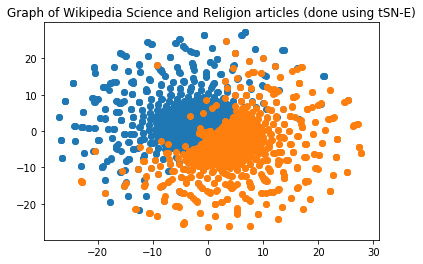

In [237]:
plt.scatter(x_embed[:700,0], x_embed[:700,1], label=1)
plt.scatter(x_embed[700:, 0], x_embed[700:,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

# III. Machine Learning

In [60]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [61]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [62]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices

In [63]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    adjacency_matrix, words_df_reduced['label'], range(adjacency_matrix.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [68]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = labels_df.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [69]:
features.shape

(1400, 100)

In [73]:
in_feats = features.shape[1] 
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(features.values) 
labels = torch.LongTensor(labels_df['label']) 
train_mask = torch.BoolTensor(train_['indices'])
val_mask = torch.BoolTensor(val_['indices'])
test_mask = torch.BoolTensor(test_['indices'])

In [74]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph = DGLGraph(graph)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 0.6931 | Val Accuracy 0.6679
Epoch 00001 | Time(s) nan | Train Loss 0.6796 | Val Accuracy 0.8143
Epoch 00002 | Time(s) nan | Train Loss 0.6624 | Val Accuracy 0.8286
Epoch 00003 | Time(s) 0.0044 | Train Loss 0.6301 | Val Accuracy 0.8393
Epoch 00004 | Time(s) 0.0044 | Train Loss 0.5823 | Val Accuracy 0.8500
Epoch 00005 | Time(s) 0.0044 | Train Loss 0.5187 | Val Accuracy 0.8571
Epoch 00006 | Time(s) 0.0043 | Train Loss 0.4698 | Val Accuracy 0.8500
Epoch 00007 | Time(s) 0.0044 | Train Loss 0.4169 | Val Accuracy 0.8500
Epoch 00008 | Time(s) 0.0044 | Train Loss 0.3957 | Val Accuracy 0.8571
Epoch 00009 | Time(s) 0.0044 | Train Loss 0.3371 | Val Accuracy 0.8571
Epoch 00010 | Time(s) 0.0044 | Train Loss 0.3189 | Val Accuracy 0.8571
Epoch 00011 | Time(s) 0.0044 | Train Loss 0.3170 | Val Accuracy 0.8679
Epoch 00012 | Time(s) 0.0044 | Train Loss 0.3001 | Val Accuracy 0.8643
Epoch 00013 | Time(s) 0.0044 | Train Loss 0.2948 | Val Accuracy 0.8679
Epoch 00014 | T

In [75]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

[ 3.0335634  -2.7560277  -0.23176661  0.7974252 ]


In [76]:
model

LaplacianPolynomial(
  in=100, out=2, normalization=True
  (dropout): Dropout(p=0.8, inplace=False)
)

In [77]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    V = np.vander(lam, len(coeff), increasing=True)
    return V@coeff

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Spectral response (db)')

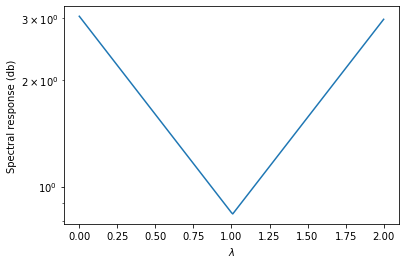

In [78]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

In [94]:
list_articles = ["God", "Network Science", "Jesus", "Quantic physics"]
test_df = aquire.take_words(list_articles, stop_words, is_title = True)

[====================] 100%

In [101]:
test_df = pd.concat([words_df_reduced,test_df])

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [104]:
features_final = nlpu.TF_IDF(test_df, 100).values
features_final

array([[0.04061253, 0.54364699, 0.26136965, ..., 0.        , 0.02633915,
        0.02359013],
       [0.        , 0.0234867 , 0.03995532, ..., 0.00609518, 0.01962889,
        0.00586007],
       [0.        , 0.06970982, 0.        , ..., 0.        , 0.        ,
        0.0695721 ],
       ...,
       [0.06131579, 0.        , 0.        , ..., 0.        , 0.00935675,
        0.01047523],
       [0.        , 0.00350141, 0.01588417, ..., 0.00363469, 0.00130057,
        0.00931865],
       [0.        , 0.        , 0.        , ..., 0.0190229 , 0.        ,
        0.01828915]])

In [105]:
distances = np.array([[(np.sum((features_final[i,:]-features_final[j,:])**2)) for i in range(0,features_final.shape[0]) ] for j in range(0,features_final.shape[0])]).reshape(features_final.shape[0],-1)
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)
graph = nx.from_numpy_array(feat)
graph = DGLGraph(graph)

In [106]:
features_ = torch.FloatTensor(features_final)

In [110]:
mask1 = np.zeros((len(features)))
mask2 = np.ones((4))
mask = np.concatenate((mask1,mask2))
mask = torch.BoolTensor(mask)

In [111]:
test_articles(model, graph, features_, mask)

tensor([0, 0, 0, 0])

## Cheeger constant

In [112]:
matrixu()

TypeError: 'MatrixUtils' object is not callable

## Heuristic Eigengaps

In [240]:
adjacency = matrixu.epsilon_similarity_graph(adjacency_matrix, sigma= 5*np.mean(distances), epsilon=0.90)
laplacian = matrixu.compute_laplacian(adjacency, normalize = False)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)

Text(0.5, 1.0, 'Eigenvalues $L_{comb}$')

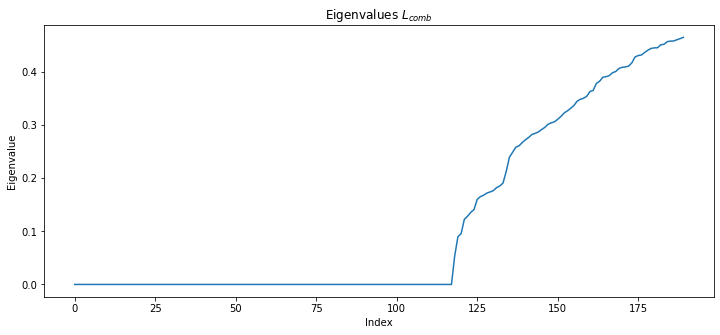

In [247]:
plt.figure(figsize=(12,5))
plt.plot(eigenvalues[10:200])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')